<a href="https://colab.research.google.com/github/Iskhand/RNN_Ternak/blob/main/Ternak/SapiPerah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf

In [ ]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
url="https://raw.githubusercontent.com/Iskhand/RNN_Ternak/main/dataset.xlsx"
df = pd.read_excel(url)
df.set_index('Tahun', inplace=True)
df

,Sapi Potong,Sapi Perah,Kambing,Kerbau,Ayam Kampung,Ayam Pedaging,Ayam Petelur,Itik,Babi
Tahun,,,,,,,,,
2006,10875125,369008,13789955,2166606,291085191,797527446,100201556,32480718,6218202
2007,11514871,374067,14470214,2085779,272251141,891659346,111488878,35866833,6710757
2008,12256604,457577,15147432,1930716,243423389,902052418,107955170,39839520,6837528
2009,12759838,474701,15815317,1932927,249963499,1026378580,111417637,40675995,6974732
2010,13581571,488488,16619599,1999604,257544104,986871711,105210062,44301804,7476665
2011,14824373,597213,16946187,1305078,264339634,1177990869,124635794,43487519,7524788
2012,15980696,611940,17905862,1438295,274564427,1244402017,138717751,49295007,7900362
2013,12686239,444266,18500321,1109636,276776576,1344191104,146621514,51355088,7598694
2014,14726875,502516,18639532,1335147,275116120,1443349117,146660415,52682954,7694131


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 2006 to 2022
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Sapi Potong    17 non-null     int64
 1   Sapi Perah     17 non-null     int64
 2   Kambing        17 non-null     int64
 3   Kerbau         17 non-null     int64
 4   Ayam Kampung   17 non-null     int64
 5   Ayam Pedaging  17 non-null     int64
 6   Ayam Petelur   17 non-null     int64
 7   Itik           17 non-null     int64
 8   Babi           17 non-null     int64
dtypes: int64(9)
memory usage: 1.3 KB


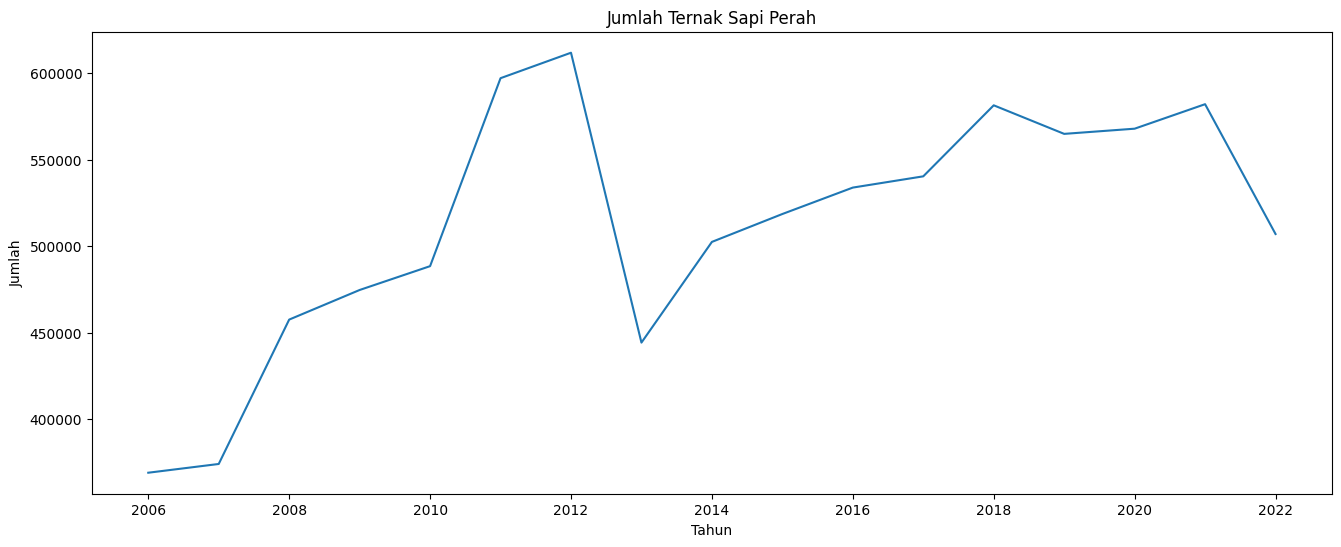

In [ ]:
plt.figure(figsize=(16, 6))
plt.title("Jumlah Ternak Sapi Perah")
plt.plot(df['Sapi Perah'])
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.show()

In [ ]:
dataset = df[['Sapi Perah']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.        ],
       [0.02082476],
       [0.3645835 ],
       [0.43507237],
       [0.49182487],
       [0.9393781 ],
       [1.        ],
       [0.30979039],
       [0.54956943],
       [0.61597896],
       [0.67889368],
       [0.70568307],
       [0.87478801],
       [0.80678132],
       [0.81912634],
       [0.8774513 ],
       [0.568336  ]])

In [ ]:
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

n_train = train_data.shape[0]
n_test = test_data.shape[0]

print("Jumlah data latih:", n_train)
print("Jumlah data uji:", n_test)

Jumlah data latih: 13
Jumlah data uji: 4


In [ ]:
def create_dataset(data, time_steps=1):
    x, y = [], []
    for i in range(time_steps, len(data)):
        x.append(data[i-time_steps:i])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

time_steps = 3
x_train, y_train = create_dataset(train_data, time_steps)
x_test, y_test = create_dataset(test_data, time_steps)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
print(x_train.shape)
print(x_test.shape)

(10, 3, 1)
(1, 3, 1)


In [ ]:
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(16),
    Dense(8),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mape'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7633 (29.82 KB)
Trainable params: 7633 (29.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
5/5 [==============================] - 5s 255ms/step - loss: 0.4140 - mape: 89.6700 - val_loss: 0.1895 - val_mape: 76.6007
Epoch 2/100
5/5 [==============================] - 0s 21ms/step - loss: 0.3243 - mape: 77.1088 - val_loss: 0.1112 - val_mape: 58.6789
Epoch 3/100
5/5 [==============================] - 0s 16ms/step - loss: 0.2379 - mape: 62.8986 - val_loss: 0.0466 - val_mape: 37.9736
Epoch 4/100
5/5 [==============================] - 0s 21ms/step - loss: 0.1618 - mape: 48.6607 - val_loss: 0.0063 - val_mape: 13.9339
Epoch 5/100
5/5 [==============================] - 0s 22ms/step - loss: 0.1043 - mape: 42.3429 - val_loss: 0.0058 - val_mape: 13.4144
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0610 - mape: 32.7923 - val_loss: 0.0447 - val_mape: 37.1823
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0650 - mape: 35.5407 - val_loss: 0.1052 - val_mape: 57.0631
Epoch 8/100
5/5 [==============================] - 0s 16ms/st

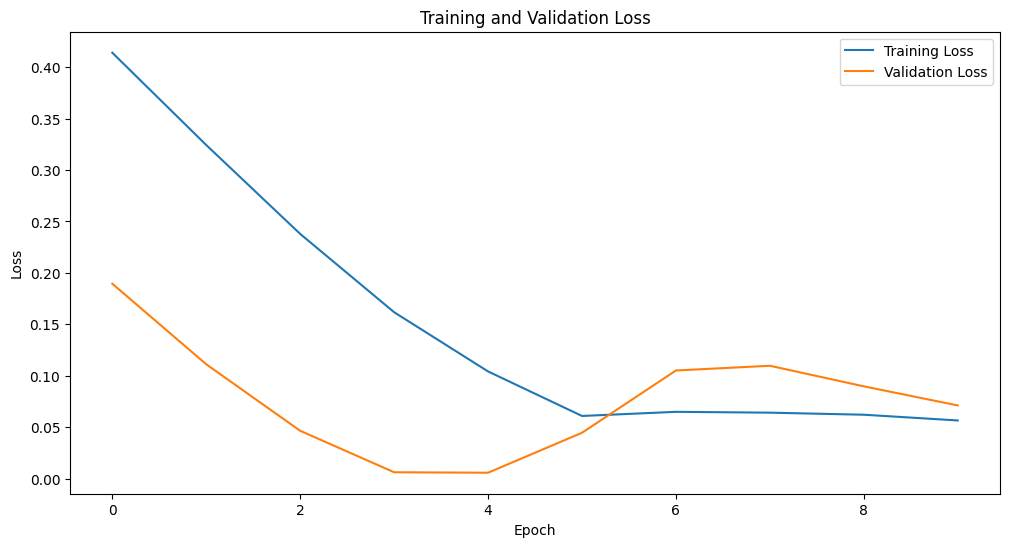

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def predict_with_sliding_window(model, data, time_steps):
    predictions = []
    for i in range(time_steps, len(data)):
        x_input = data[i-time_steps:i].reshape((1, time_steps, 1))
        y_pred = model.predict(x_input)
        predictions.append(y_pred[0, 0])
    return np.array(predictions)

test_data_full = scaled_data[train_size-time_steps:]

predictions_full = predict_with_sliding_window(model, test_data_full, time_steps)
predictions_full = scaler.inverse_transform(predictions_full.reshape(-1, 1))

y_test_full = dataset['Sapi Perah'].values[train_size:]

1/1 [==============================] - 0s 75ms/step


In [ ]:
test_df_full = dataset.iloc[train_size:].copy()
test_df_full['Predictions'] = np.nan
test_df_full.iloc[:len(predictions_full), test_df_full.columns.get_loc('Predictions')] = predictions_full.flatten()
print("Data Test dengan Prediksi:")
print(test_df_full)

Data Test dengan Prediksi:
       Sapi Perah   Predictions
Tahun                          
2019       565001  514832.21875
2020       568000  521090.75000
2021       582169  527329.37500
2022       507075  525595.87500


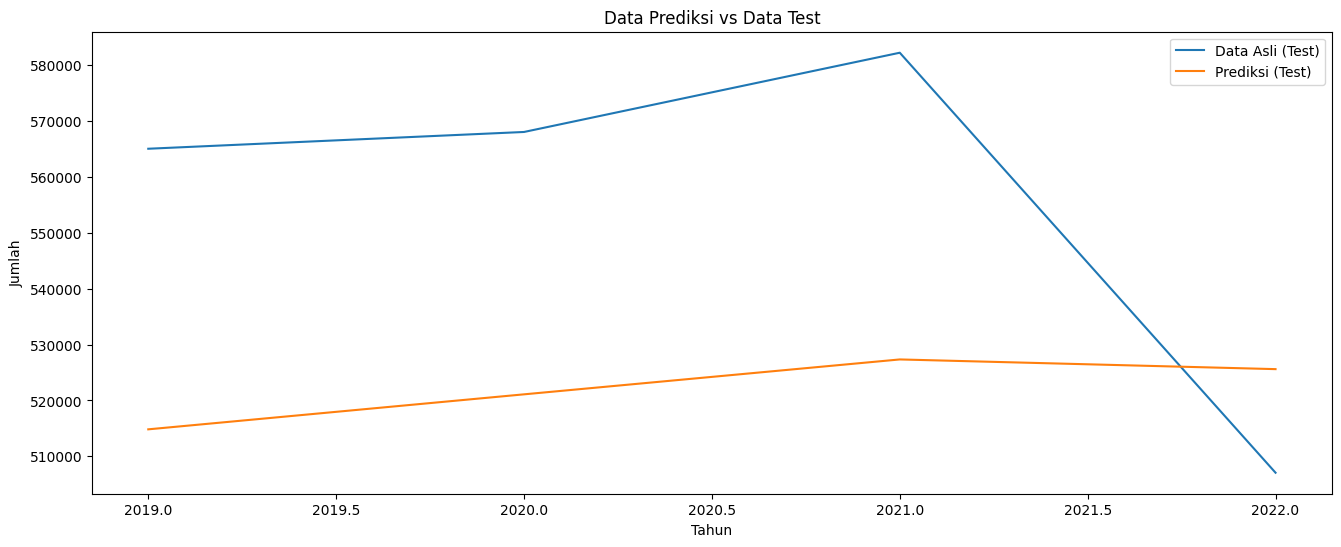

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(dataset.index[train_size:], y_test_full, label='Data Asli (Test)')
plt.plot(dataset.index[train_size:], predictions_full, label='Prediksi (Test)')
plt.title('Data Prediksi vs Data Test')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.legend()
plt.show()

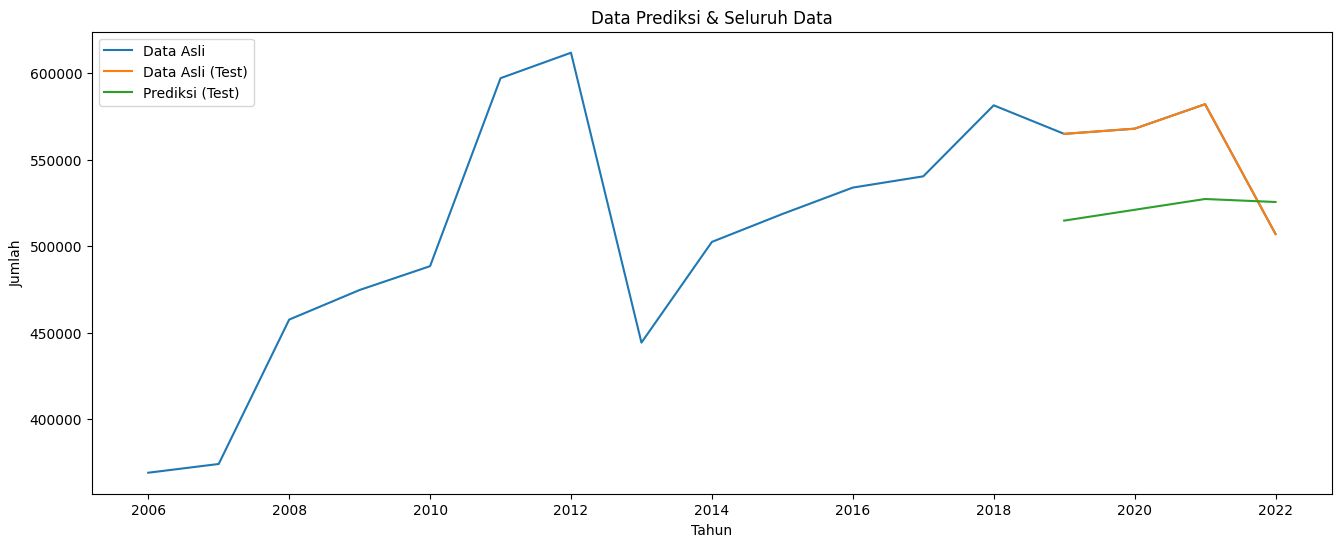

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(dataset.index, dataset['Sapi Perah'], label='Data Asli')
plt.plot(dataset.index[train_size:], y_test_full, label='Data Asli (Test)')
plt.plot(dataset.index[train_size:], predictions_full, label='Prediksi (Test)')
plt.title('Data Prediksi & Seluruh Data')
plt.xlabel('Tahun')
plt.ylabel('Jumlah')
plt.legend()
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_full, predictions_full))
mape = mean_absolute_percentage_error(y_test_full, predictions_full.flatten()) * 100

print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

RMSE: 44910.443185797834
MAPE: 7.55261456417331


1/1 [==============================] - 0s 21ms/step
      Predicted_Jumlah
2023      521856.34375
2024      514488.62500
2025      500672.68750
2026      501390.84375
2027      497842.37500
2028      494834.90625
2029      494188.06250
2030      492957.21875
2031      492145.03125
2032      491759.15625
2033      491354.40625
2034      491097.43750
2035      490936.46875
2036      490802.09375
2037      490714.46875


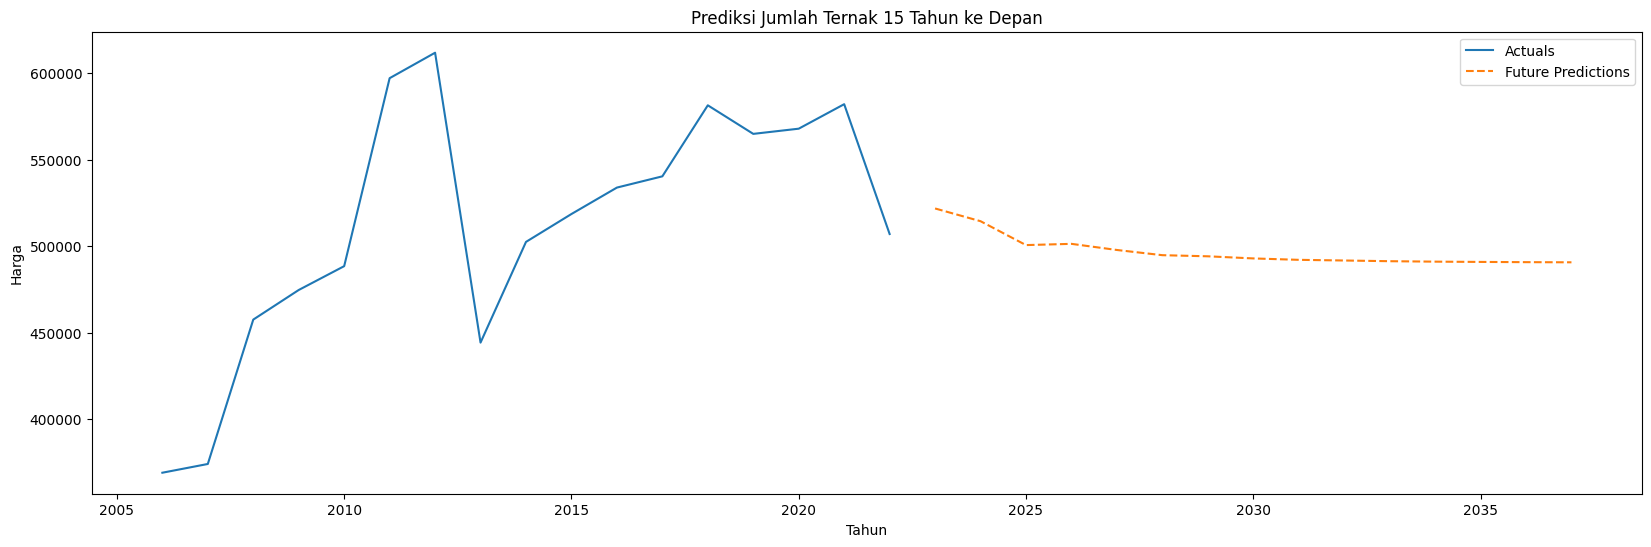

In [ ]:
n_years = 15
last_data = scaled_data[-time_steps:]

future_predictions = []
for _ in range(n_years):
    pred = model.predict(last_data.reshape(1, time_steps, 1))
    future_predictions.append(pred[0, 0])
    last_data = np.append(last_data[1:], pred[0, 0]).reshape(time_steps, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_year = df.index[-1]
future_years = [last_year + i for i in range(1, n_years + 1)]
future_df = pd.DataFrame(data=future_predictions, index=future_years, columns=['Predicted_Jumlah'])

print(future_df)

plt.figure(figsize=(20, 6))
plt.plot(df['Sapi Perah'], label='Actuals')
plt.plot(future_df['Predicted_Jumlah'], label='Future Predictions', linestyle='--')
plt.title(f'Prediksi Jumlah Ternak {n_years} Tahun ke Depan')
plt.xlabel('Tahun')
plt.ylabel('Harga')
plt.legend()
plt.show()